1.4101263968509032
7
12


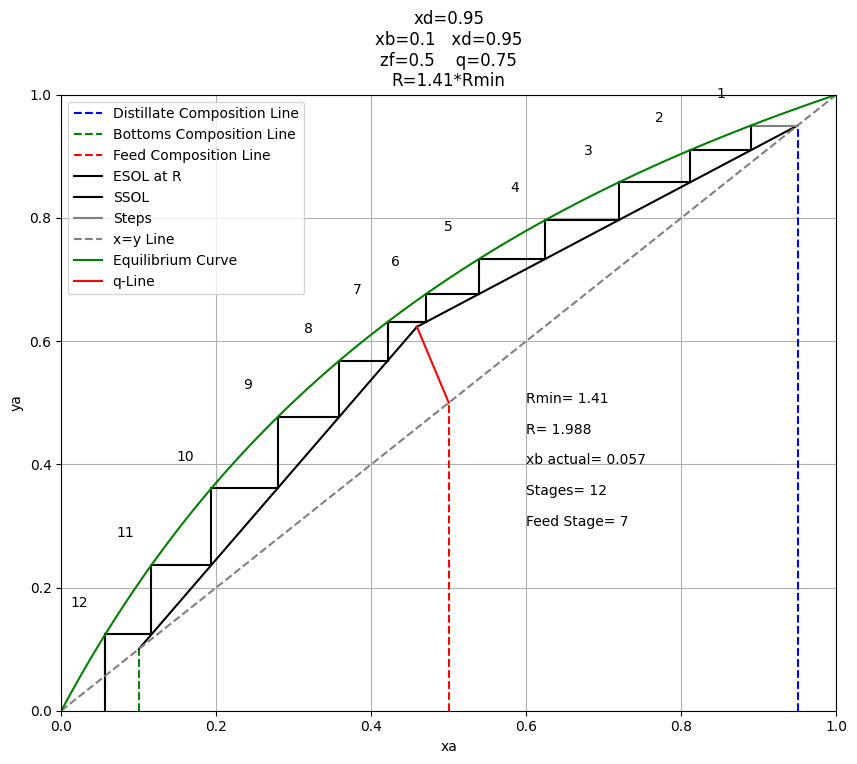

In [9]:
import numpy as np 
import matplotlib.pyplot as plt 


def eq_og(xa,relative_volatility):
    ''' 
    DESCRIPTION
    Returns equilibrium data from an input 
    of liquid composition (xa) and relative volatility

    INPUTS: 
    xa                      : Liquid Composition
    relative_volatility     : Relative Volatility

    OUTPUTS: 
    ya                      : Vapour Composition 
    '''
    ya=(relative_volatility*xa)/(1+(relative_volatility-1)*xa)
    # ya found using Dalton and Raoults laws
    return ya

def eq(xa,relative_volatility,nm):
    ''' 
    DESCRIPTION
    Returns equilibrium data from an input 
    of liquid composition (xa) and relative volatility
    accounting for the Murphree Efficiency of the 
    system

    INPUTS: 
    xa                      : Liquid Composition
    relative_volatility     : Relative Volatility
    nm                      : Murphree Efficiency

    OUTPUTS: 
    ya                      : Vapour Composition 
    '''
    ya=(relative_volatility*xa)/(1+(relative_volatility-1)*xa)
    # ya found using Dalton and Raoults laws
    ya=((ya-xa)*nm)+xa # using definition of murphree efficiency 
    return ya

def eq2(ya,relative_volatility,nm):
    ''' 
    DESCRIPTION
    Returns equilibrium data from an input 
    of liquid composition (ya) and relative volatility
    accounting for the Murphree Efficiency of the 
    system. This function is the inverse of eq(...) above.

    INPUTS: 
    ya                      : Vapour Composition
    relative_volatility     : Relative Volatility
    nm                      : Murphree Efficiency

    OUTPUTS: 
    xa                      : Liquid Composition 
    '''
    # inverse of eq() takes the form of a quadratic
    a=((relative_volatility*nm)-nm-relative_volatility+1)
    b=((ya*relative_volatility)-ya+nm-1-(relative_volatility*nm))
    c=ya
    xa=(-b-np.sqrt((b**2)-(4*a*c)))/(2*a) # solving quadratic using 
                                          # quadratic formula
    return xa

def stepping_ESOL(x1,y1,relative_volatility,R,xd):
    '''
    DESCRIPTION:
    Performs a single step over the ESOL
    operating line.

    INPUTS: 
    x1                      : Initial liquid composition on ESOL
    y1                      : Initial vapour composition on ESOL
    relative_volatility     : Relative Volatility
    R                       : Reflux Ratio
    xd                      : Distillate Composition

    OUTPUTS: 
    x1      : Initial liquid composition 
    x2      : Liquid composition after stepping
    y1      : Initial vapour composition
    y2      : Vapour composition after stepping

    '''
    x2=eq2(y1,relative_volatility,nm) #getting new liquid comp 
    y2=(((R*x2)/(R+1))+(xd/(R+1))) #ESOL equation 
    return x1,x2,y1,y2

def stepping_SSOL(x1,y1,relative_volatility,\
ESOL_q_x,ESOL_q_y,xb):
    '''
    DESCRIPTION:
    Performs a single step over the SSOL
    operating line.

    INPUTS: 
    x1                      : Initial liquid composition on ESOL
    y1                      : Initial vapour composition on ESOL
    relative_volatility     : Relative Volatility
    ESOL_q_x                : Point at which ESOL intersects q-line (x)
    ESOL_q_y                : Point at which ESOL intersects q-line (y)
    xb                      : Bottoms composition 

    OUTPUTS: 
    x1      : Initial liquid composition 
    x2      : Liquid composition after stepping
    y1      : Initial vapour composition
    y2      : Vapour composition after stepping

    '''
    x2=eq2(y1,relative_volatility,nm) # getting new liquid comp
    m=((xb-ESOL_q_y)/(xb-ESOL_q_x)) # gradient of SSOL
    c=ESOL_q_y-(m*ESOL_q_x) # intercept of SSOL
    y2=(m*x2)+c # SSOL equation in form 'y=mx+c'
    return x1,x2,y1,y2

def McCabeThiele(PaVap,PbVap,R_factor,xf,xd,xb,q,nm):
    '''
    DESCRIPTION: 
    Performs the McCabe-Thiele construction in order to calculate
    optimum number of stages, and optimum feed stage. Also taking into 
    account the Murphree Efficiency of the system. 

    INPUTS: 
    PaVap       :Vapour pressure of component a (more volatile)
    PbVap       :Vapour pressure of component b (less volatile)
    R_factor    :Amount Rmin is scaled by to obtain the actual reflux ratio
    xf          :Feed composition 
    xd          :Distillate composition 
    xb          :Bottoms composition 
    q           :Liquid fraction of feed
    nm          :Murphree Efficiency

    OUTPUTS: 
    A McCabe-Thiele plot, displaying optimum number of equilibrium stages, 
    optimum feed stage, actual reflux ratio, actual bottoms composition. 
    '''
    # Ensuring errors don't occur regarding dividing by 0
    if q==1:
        q-=0.00000001
    if q==0:
        q+=0.00000001

    relative_volatility=PaVap/PbVap #obtaining relative volatility from definition 
    xa=np.linspace(0,1,100) #creating x-axis
    ya_og=eq_og(xa[:],relative_volatility) #getting original equilibrium data
    ya_eq=eq(xa[:],relative_volatility,nm) #getting modified equilibrium data 
    # taking into account the Murphree Efficiency 

    x_line=xa[:] #creating data-points for y=x line
    y_line=xa[:]
    
    # finding where the q-line intersects the equilibrium curve 
    # takes the form of a quadratic equation 
    al=relative_volatility
    a=((al*q)/(q-1))-al+(al*nm)-(q/(q-1))+1-nm
    b=(q/(q-1))-1+nm+((al*xf)/(1-q))-(xf/(1-q))-(al*nm)
    c=xf/(1-q)

    if q>1:
        q_eqX=(-b+np.sqrt((b**2)-(4*a*c)))/(2*a)
    else: 
        q_eqX=(-b-np.sqrt((b**2)-(4*a*c)))/(2*a)
    # where the q-line intersects the equilibrium curve (x-axis)
    q_eqy=eq(q_eqX,relative_volatility,nm)
    # where the q-line intersects the equilibrium curve (y-axis)

    theta_min=xd*(1-((xd-q_eqy)/(xd-q_eqX))) # ESOL y-intercept to obtain Rmin
    R_min=(xd/theta_min)-1 # finding Rmin
    R=R_factor*R_min # multiplying by R_factor to obtain R
    theta=(xd/(R+1)) # finding new ESOL y-intercept
    print(R_min)

    ESOL_q_x=((theta-(xf/(1-q)))/((q/(q-1))-((xd-theta)/xd)))
    # Where the new ESOL intercepts the q-line (x-axis)
    ESOL_q_y=(ESOL_q_x*((xd-theta)/xd))+theta
    # Where the new ESOL intercepts the q-line (y-axis)


    plt.figure(figsize=(10, 8))  # Tạo một hình có kích thước lớn hơn
    plt.axis([0, 1, 0, 1])  # Tạo các trục từ 0 đến 1

    # Vẽ các đường dạng chấm
    plt.plot([xd, xd], [0, xd], color='blue', linestyle='--', label='Distillate Composition Line')
    plt.plot([xb, xb], [0, xb], color='green', linestyle='--', label='Bottoms Composition Line')
    plt.plot([xf, xf], [0, xf], color='red', linestyle='--', label='Feed Composition Line')

    # Vẽ ESOL và SSOL
    plt.plot([xd, ESOL_q_x], [xd, ESOL_q_y], color='black', label='ESOL at R')
    plt.plot([xb, ESOL_q_x], [xb, ESOL_q_y], color='black', label='SSOL')


    # Bước đi trên ESOL
    step_count = 1
    x1, x2, y1, y2 = stepping_ESOL(xd, xd, relative_volatility, R, xd)
    plt.plot([x1, x2], [y1, y1], color='grey', label='Steps')
    plt.plot([x2, x2], [y1, y2], color='black')
    plt.text(x2 - 0.045, y1 + 0.045, step_count)
    while x2 > ESOL_q_x:
        x1, x2, y1, y2 = stepping_ESOL(x2, y2, relative_volatility, R, xd)
        plt.plot([x1, x2], [y1, y1], color='black')
        plt.plot([x2, x2], [y1, y2], color='black')
        step_count += 1
        plt.text(x2 - 0.045, y1 + 0.045, step_count)

    feed_stage = step_count
    print(feed_stage)

    # Bước đi trên SSOL
    x1, x2, y1, y2 = stepping_SSOL(x1, y1, relative_volatility, ESOL_q_x, ESOL_q_y, xb)
    plt.plot([x1, x2], [y1, y1], color='black')
    plt.plot([x2, x2], [y1, y2], color='black')
    step_count += 1
    while x2 > xb:
        x1, x2, y1, y2 = stepping_SSOL(x2, y2, relative_volatility, ESOL_q_x, ESOL_q_y, xb)
        plt.plot([x1, x2], [y1, y1], color='black')
        plt.plot([x2, x2], [y1, y2], color='black')
        plt.text(x2 - 0.045, y1 + 0.045, step_count)
        step_count += 1
    plt.plot([x2, x2], [y1, 0], color='black')
    xb_actual = x2
    stages = step_count - 1
    plt.plot(x_line, y_line, color='grey', linestyle='--', label='x=y Line')
    plt.plot(xa, ya_og, color='green', linestyle='-', label='Equilibrium Curve')
    plt.plot([xf, ESOL_q_x], [xf, ESOL_q_y], color='red', label='q-Line')
    print(stages)

    #plt.plot([ESOL_q_x,q_eqX],[ESOL_q_y,q_eqy],color='r',linestyle='--') #q- line
    '''UN-COMMENT TO SEE FULL q LINE ^^^'''

    # Chú thích
    plt.xlabel('xa')
    plt.ylabel('ya')
    plt.text(0.6, 0.5, 'Rmin= ' + str(round(R_min, 3)))
    plt.text(0.6, 0.45, 'R= ' + str(round(R, 3)))
    plt.text(0.6, 0.4, 'xb actual= ' + str(round(xb_actual, 3)))
    plt.text(0.6, 0.35, 'Stages= ' + str(stages))
    plt.text(0.6, 0.3, 'Feed Stage= ' + str(feed_stage))
    plt.title('xd=' + str(xd) + '\n' + 'xb=' + str(xb) + '   xd=' + str(xd) + '\n' +
              'zf=' + str(xf) + '    q=' + str(round(q, 3)) + '\n' +
              'R=' + str(R_factor) + '*Rmin')
    plt.grid(True)
    plt.legend()  # Thêm hộp chú thích
    plt.show()
    return 


'''PARAMETERS'''

PaVap=160     # Vapour pressure of a
PbVap=68      # Vapour pressure of b 
xd=0.95      # Distillate composition 
xb=0.1       # Bottoms composition 
xf=0.5       # Feed composition 
q=0.75           # q 
R_factor=1.41  # Reflux ratio = R_min* R_factor
nm= 0.999999999999 


McCabeThiele(PaVap,PbVap,R_factor,xf,xd,xb,q,nm)